# 1. Author

**Student Name**:  BINEETA KACHHAP

**Student ID**:  210619025



# 2. Problem formulation

**Basic solution** : Using the MLEnd Hums and Whistles dataset, a machine learning pipeline has been build that takes as an input a Potter or a StarWars audio segment and predicts its song label (either HarryPotter or StarWars).

# 3. Machine Learning pipeline

For the basic solution of classification, following stages and methods have been implemented to build a model. 

1. **Data Load**: Loading the .wav files from the link provided in the MLEnd Hums and Whistles.
2. **Identify Label**: All the files from the drive where read and anlaysed to identify the label classification.
3. **Feature Extraction**: The .wav files were read and multiple features like MFCC, STFT, Spectral Centroids, Roll-Off, Spectral Flux, Chromagram for each note was extracted.  
4. **Component Analysis**: after feature extraction, Principle compoenet analysis was performed to understand the standout features that woudl assist in classification.
5. **Modelling with Pipeline**: The machine learning model where implemented. The pipeline for the ML includes 
> * Standard Scaler: The training data is normalised with mean μ and standard deviation σ
> * Feature Selection: SelectkBest()
> * Classifier Model 
6. **Model/Training Analysis**: The model training accuracy for each test was analysedusing the cross_val_score. The method of confusion matrix has been used to calculate the Precision, Recall accuracy for each of the class and analyse further the training and validation accuracy. 
7. **Validation/Test Analysis**: The validation accuracy was calculated and the method of confusion matrix has been used to calculate the Precision, Recall accuracy for each of the class for the validation.


The code cell has been partitioned into section and below is the brief description of each section. The stages have been deatiled out as we further go down the project.

---
**Code Section - A** : Importing all the libraries


In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display
import sklearn

import seaborn as sns
from scipy import stats
from sklearn import svm

from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.manifold import MDS
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

**Code Section - B** : Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Code Section - C** : The below set of code has been re-used form starters kit was required to be executed ones to load the data and unzip and the data to the google drive mount location

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())


In [ ]:
potter_url  = "https://collect.qmul.ac.uk/down?t=6122TDAA73VPCMDQ/5DSHD27BLQMK5S8E1HLG19O"
save_path = '/content/drive/MyDrive/Data/MLEndHW/Potter_1.zip'
download_url(potter_url, save_path)

starWars_url  = "https://collect.qmul.ac.uk/down?t=650T7K3FAE26MB29/592IN2FALUM43SGC35O0580"
save_path = '/content/drive/MyDrive/Data/MLEndHW/StarWars_1.zip'
download_url(starWars_url, save_path)

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndHW/miniproject/'
zip_path = '/content/drive/MyDrive/Data/MLEndHW/Potter_1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEndHW/miniproject/'
zip_path = '/content/drive/MyDrive/Data/MLEndHW/StarWars_1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# 4. Transformation stage

**Code Section - D : Identify Labels**

The below set of code in Section has been implemented to;
* loads the individual files from the drive location. Function getDriveFiles() return all the list of files for the analysis.
* The list of files are iterated and each filename is applied lowercase, splits, stores individual values in array **splitFileName**
* **splitFileName** is passed to an utility function **validateFileName** which validates the names rectifies any human error input and return an correct version of the name. **errorLists_Dict** is created with set of error filenames.
* **Label_Error_Analysis.txt** file is generated to check if there was any error in the naming convention and **errorLists_Dict** was updated with releveant new errorlist.
* The updated corrected version of the file names are then loaded into MLENDHW_df dataframe and saved into **MLENDHW_Label_basic.csv** for further use.
* The below set of code needs to be executed ones. for further execution **MLENDHW_Label_basic.csv** can be loaded.


E.g.: Example of **Label_Error_Analysis.txt** of error. for the below Error 'Imperial' was added in **errorLists_Dict**

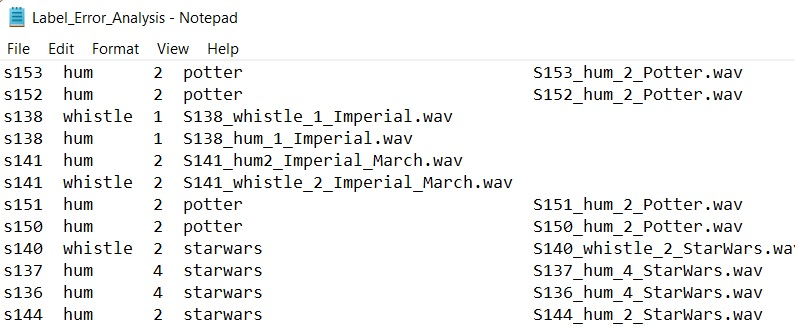

In [ ]:
errorLists_Dict = {'starwars': ['starwars', 'starwar','star', 'war', 'stars', 'imperial'],
                   'showman': ['showman', 'this','snowman'],
                   'rain': ['rain', 'sing'],
                   'potter': ['harry', 'potter'],
                   'panther': ['panther', 'pink','pinkpanther','panter'],
                   'mamma': ['mamma','mia','mama','mumma'],
                   'hakuna': ['hakuna','matata','haknua','hukuna','hakana'],
                   'frozen': ['frozen','let','it','go']}
# utility function to validate the filename and return the appropriate class labels
def validateFileName(splitFileName):

  newSplitFileName = []
  id = splitFileName[0]
  newSplitFileName.append(id)

  splitFileName.remove(id)

  result = any(elem.find('hum') > -1 for elem in splitFileName)   
  if result:
    newSplitFileName.append('hum')
  else :
    newSplitFileName.append('whistle')

  for i in range(1,5,1):
    result = any(elem.find(str(i)) > -1 for elem in splitFileName)
    if result:
      newSplitFileName.append(str(i))

  for key in errorLists_Dict:
    errorList = errorLists_Dict[key]
    for errorWord in errorList:
      result = any(elem.find(errorWord) > -1 for elem in splitFileName)
      if result:
        newSplitFileName.append(key)
        break

  #newSplitFileName = ['s108_whistle_1_singingintherain.wav','s108', 'whistle', '1', 'rain'])
  return newSplitFileName


In [ ]:
# utility function to retrieve file from the location
def getDriveFiles():
  drive.mount('/content/drive')
  path = '/content/drive/MyDrive/Data/MLEndHW'
  os.listdir(path)
  filePath = '/content/drive/MyDrive/Data/MLEndHW/miniproject/*.wav'
  files = glob.glob(filePath)
  print(len(files))
  return files

In [ ]:
import re
MLENDHW_table = [] 
files = getDriveFiles()
for file in files:
  fileName = file.split('/')[-1]
  temp_fileName = fileName.lower()
  temp_fileName = temp_fileName.replace(' ', '')
  splitFileName = re.split('_|\.',temp_fileName)
  splitFileName = validateFileName(splitFileName)
  splitFileName.append(fileName)
  MLENDHW_table.append(splitFileName) 

from tabulate import tabulate
with open('Label_Error_Analysis.txt', 'w') as outputfile:
    outputfile.write(tabulate(MLENDHW_table))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
824


In [ ]:
MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['participant','interpretation','number','song','file_id']).set_index('file_id') 
MLENDHW_df
MLENDHW_df.to_csv('MLENDHW_Label_basic.csv')  

In [ ]:
MLENDHW_df = pd.read_csv('MLENDHW_Label_basic.csv')
MLENDHW_df.head()

,file_id,participant,interpretation,number,song
0,S1_hum_2_Potter.wav,s1,hum,2,potter
1,S3_hum_2_Potter.wav,s3,hum,2,potter
2,S1_whistle_2_Potter.wav,s1,whistle,2,potter
3,S3_hum_1_Potter.wav,s3,hum,1,potter
4,S2_whistle_2_Potter.wav,s2,whistle,2,potter




---


**Code Section - E : Feature Extraction**

The below set of code extracts numerical information from the .wav 
* Features like MFCC, STFT, Spectral Centroids, Roll-Off, Spectral Flux, Chromagram for each note was extracted. getFeatures method is used wher the list of .wav files are passed and it return.
>* X_data with features extracted for each song in array form the. The array if os shape (Number of song,  Number of feature)
>* y_data : class label for each of the son fetched from the MLENDHW_df dataframe.
>* fileId : list of filenames.

* The extracted features are then loaded into dataframe and saved into **MLEndHW_mini_projectCompleteData.csv** for further use.
* The below set of code needs to be executed ones. for further execution **MLEndHW_mini_projectCompleteData.csv** can be loaded.
* From the csv, the data is saved into dataframe **df** or as numpy array **X_all, y_all** based on usage.
* For this classification project, The data with label as Potter are considered as True and the data labelled as StarWars are considered as False.

In [ ]:
def getMeanStd(feature):
  featureMean = np.nanmean(feature) if np.mean(np.isnan(feature))<1 else 0
  featureStd = np.nanstd(feature) if np.mean(np.isnan(feature))<1 else 0
  return featureMean, featureStd

In [ ]:
#utility funtion to fetch all the related feature for a .wav
def getFeatures(files,labels_file,scale_audio=False):
  
  X,y,fileID =[],[],[]
  winLen=0.02
 
  
  for file in tqdm(files):
    file_ID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[file_ID]['song']=='potter'

    fs = None # Sampling frequency. If None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    
    power = np.sum(x**2)/len(x)
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, sr=fs,frame_length=frame_length,hop_length=hop_length)
    stft = np.abs(librosa.stft(x))
    mfcc = librosa.feature.mfcc(y=x, sr=fs)
    amplitude = librosa.amplitude_to_db(x)
    zRate = librosa.feature.zero_crossing_rate(x)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=fs)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=fs)[0]
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=fs)[0]
    spectralFlux = librosa.onset.onset_strength(y=x, sr=fs)

    voiced_fr = np.mean(voiced_flag)
    voiced_pr = np.mean(voiced_probs)
    pitch_mean, pitch_std = getMeanStd(f0)
    stft_mean,stft_std = getMeanStd(stft)
    mfcc_mean,mfcc_std = getMeanStd(mfcc)
    flux_mean,flux_std = getMeanStd(spectralFlux)
    amp_mean,amp_std = getMeanStd(amplitude)
    zRate_mean,zRate_std = getMeanStd(zRate)
    centroid_mean,centroid_std = getMeanStd(spectral_centroids)
    rolloff_mean,rolloff_std = getMeanStd(spectral_rolloff)
    bandwidth_mean,bandwidth_std = getMeanStd(spectral_bandwidth_2)
    

    xi = [power, pitch_mean, pitch_std,voiced_fr, voiced_pr,
          stft_mean, stft_std, mfcc_mean, mfcc_std,flux_mean,flux_std,amp_mean,amp_std,zRate_mean,zRate_std,
          centroid_mean, centroid_std, rolloff_mean, rolloff_std, bandwidth_mean, bandwidth_std]
    chromagram = librosa.feature.chroma_stft(y=x, sr=fs)
    for row in chromagram:
      node_mean, node_std = getMeanStd(row)
      xi.append(node_mean)
      xi.append(node_std)
    X.append(xi)
    y.append(yi)
    fileID.append(file_ID)
  return np.array(X),np.array(y),np.array(fileID)


In [ ]:
X_Data,y_Data, fileIds = getFeatures(files, labels_file=MLENDHW_df,scale_audio=True)

100%|██████████| 824/824 [56:18<00:00,  4.10s/it]


In [ ]:
df = pd.DataFrame(data=X_Data, columns=['power','pitch_mean', 'pitch_std','voiced_fr', 'voiced_pr',
          'stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std','amp_mean','amp_std','zRate_mean','zRate_std',
          'centroid_mean', 'centroid_std', 'rolloff_mean', 'rolloff_std', 'bandwidth_mean', 'bandwidth_std',
          'C_mean', 'C_std', 'C#_mean', 'C#_std', 'D_mean', 'D_std', 'D#_mean', 'D#_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
          'F#_mean', 'F#_std', 'G_mean', 'G_std', 'G#_mean', 'G#_std', 'A_mean', 'A_std', 'A#_mean', 'A#_std', 'B_mean', 'B_std'])
df['class'] = y_Data
df.to_csv('MLEndHW_mini_projectCompleteData.csv')


In [ ]:
df = pd.read_csv('MLEndHW_mini_projectCompleteData.csv')
df = df.iloc[: , 1:]
print(df)

        power  pitch_mean  pitch_std  ...    B_mean     B_std  class
0    0.000040  107.628769  14.832539  ...  0.663497  0.288463   True
1    0.007701  178.451926  26.961858  ...  0.255625  0.290777   True
2    0.000006  408.684951  31.757141  ...  0.397028  0.357297   True
3    0.015373  184.280074  27.611400  ...  0.211959  0.275691   True
4    0.000017  396.012292  40.644200  ...  0.288888  0.376160   True
..        ...         ...        ...  ...       ...       ...    ...
819  0.000625  154.473402  29.455200  ...  0.401532  0.295546  False
820  0.000705  241.701798  20.043909  ...  0.673070  0.333654  False
821  0.001397  234.438717  18.700408  ...  0.572083  0.265920  False
822  0.000949  330.565703  62.570922  ...  0.211864  0.321588  False
823  0.001164  394.135095  39.250296  ...  0.108578  0.228260  False

[824 rows x 46 columns]


**Code Section - F** : Feature Analysis 

* Principle Component analysis was implemented to reduce the dimension and get an overview of the chosen feature. As PCA estimated the eucledian distance between the feature to reduce the numerosity on feature, this method can be used for componenet analysis.
* **df_analysis_all**: contains all the feature and the corresponding scatter plot shows that the data is scattered. 
* **df_analysis_some**: contains some selected feature and the corresponding scatter plot shows that the data can be somewhat differentiated. 
* After multiple iteration, attributes from df_analysis_some are chosen to proceed with further analysis for this solution.

In [ ]:
df_analysis_all = df.drop('class', axis=1)
df_analysis_some = df[['stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std',
                'C_mean', 'C_std', 'D_mean', 'D_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
                'G_mean', 'G_std', 'A_mean', 'A_std', 'B_mean', 'B_std'
                ]]

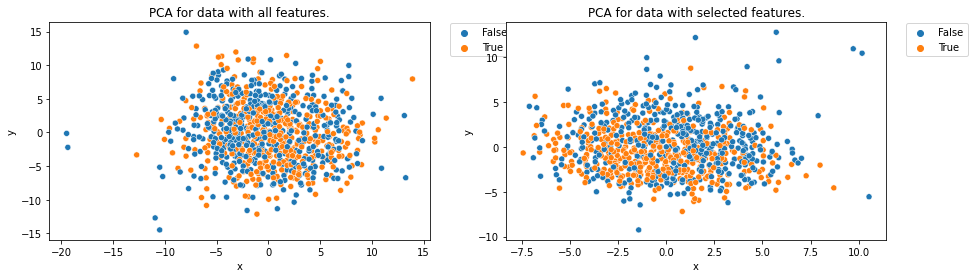

In [ ]:
# Plot 3D scatterplot of outlier scores
fig = plt.figure(figsize=(15,4))

#PCA for data with all features
standardisedDF = df_analysis_all.apply(stats.zscore)
embedding = MDS(n_components=2)
Xp = embedding.fit_transform(standardisedDF)
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1]})
df_projection['Class'] = y_all
## Scatter plot for df_analysis_all
ax = fig.add_subplot(121)
sns.scatterplot(x='x', y='y', hue='Class', data=df_projection)
plt.title('PCA for data with all features.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)

#PCA for data with selected features
standardisedDF = df_analysis_some.apply(stats.zscore)
embedding = MDS(n_components=2)
Xp = embedding.fit_transform(standardisedDF)
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1]})
df_projection['Class'] = y_all
## Scatter plot for df_analysis_some
ax = fig.add_subplot(122)
sns.scatterplot(x='x', y='y', hue='Class', data=df_projection)
plt.title('PCA for data with selected features.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
plt.show()

In [ ]:
y_all = df['class']
X_all = df[['stft_mean', 'stft_std', 'mfcc_mean', 'mfcc_std','flux_mean','flux_std',
                'C_mean', 'C_std', 'D_mean', 'D_std', 'E_mean' , 'E_std', 'F_mean', 'F_std', 
                'G_mean', 'G_std', 'A_mean', 'A_std', 'B_mean', 'B_std'
           ]].to_numpy()

# 5. Modelling

For this basic solution to classify between HarryPotter and Starwars: two models have been implemented and validation is carried out with the test data. SVC and KNN were chosen as proximity of the individual features had to be calculated to understand and classify the two sets of data.

* **Support Vector Classification**:  SVC has been used as one of the model, where the regularization parameter was set to C=[0.1, 0.5, 1, 5, 10]. Regularization parameter avoid any misclassification while the training the model. 
 
* **KNearestNeighbour**: the KNN model has ben used with n_neighbors=[11, 25, 75, 111]. As 70% of the data (800+) is used for training the data, so about 250 data wouls be present for each class while training the module. The range of odd number [11, 25, 75, 111] within 250 has been chosen for k.



# 6. Methodology

Following methodology has ben used to build the model.
* **train_test_split**: Data are split into **70% training data and 30% Validation data** set as we can see in code Section G. 70% Training data is used to build the model.
* **Standard Scaler**: transformation has been used to normalised the feature. 
* **Feature selection**: As there are about 40+ featured extracted from the signla data. SelectkBest() method has been used to select the best features for the model. The feature selection was set with data from k=[4, 8, 16, 20].
* **RepeatedStratifiedKFold**: repeated Cross validation method has been used to internally validated. With parameters as **n_splits=10**, the 70% of training data is internally split into 10 parts and cross validator repeates the test **n_repeats=10** times with randomized set. 10*10 set of data are being fit by the model and evaluated.
* **GridSearchCV**: Grid Search Cross validation is used to validate with various parameter set for individual model. The param_grid is set with various range of parameter to select the best parameter to build the model.
* **cross_val_score**: is used to analyse the accuracy for each model while training with different paramter passed for the SVC or KNN model. The mean accuracy is shown in the below implementation after all the iteration os training data is tested. 
* **Confusion Matrix**: is used to analyse the Precision, recall and accuracy for each class after the model is build utility function **predictScoreAndPlot** is implemented to build the matrix. The utlity is implemented to validate both Training and Validation Data.



**Code Section - G** : Data-Set Split 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_all,y_all,test_size=0.3, random_state=21)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 20), (248, 20), (576,), (248,))

# 7. Dataset

The Preprocessing of the data/feature selection and deatiled description has been done in the Code Section - F.

Following steps have been included in the pipeline as part of pre-processing the data.
* **train_test_split**: Data are split into **70% training data and 30% Validation data** set as we can see in code Section G. 70% Training data is used to build the model.
* **Standard Scaler**: transformation has been used to normalised the feature. 
* **Feature selection**: As there are about 40+ featured extracted from the signla data. SelectkBest() method has been used to select the best features for the model.
* **PCA**: has been implemented in Code Section - F  to analyse the feature to be used. 



**Code Section - H** : Modelling 




In [ ]:
def predictScoreAndPlot(model, X, y):
  y_pred = model.predict(X)

  precision, recall, fscore, _ = precision_recall_fscore_support(y, y_pred)

  print('\nPrecision for each class: {0}'.format(precision))
  print('Recall for each class: {0}'.format(recall))
  print('Accuracy for each class: {0}'.format(fscore))

  confusionMatrix = pd.DataFrame.from_records(confusion_matrix(y, y_pred))
  print('Confusion matrix for Data:')
  display(confusionMatrix)


* Support Vector Classifier

In [ ]:
## feature selection, Cross validation parameter, build Pipeline, Paramterset for GridSearch, Training the KNN Model
selection = SelectKBest()
scaler = StandardScaler()
svc = SVC()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("svm", svc)])
param_grid = dict(features__k=[4, 8, 16, 20],
                  svm__C=[0.1, 0.5, 1, 5, 10])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=21)
svcModel= GridSearchCV(pipeline, param_grid=param_grid, cv=cv)

svcModel.fit(X_train, y_train)
# print the accuracy result for each of the tests
n_scores = cross_val_score(svcModel, X_train, y_train, scoring='accuracy', n_jobs=-1)

In [ ]:
# Training performance Report
print('Grid Search Best parameter selected:',svcModel.best_estimator_)
print('\nAccuracy through K Fold: {0}'.format(np.around(n_scores, 4)))
print('Overall Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
predictScoreAndPlot(svcModel, X_train, y_train)
print('\nTraining Accuracy: {0}'.format(svcModel.score(X_train, y_train)))

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=20)),
                ('svm', SVC(C=1))])

Accuracy through K Fold: [0.7414 0.7304 0.6609 0.6783 0.6783]
Overall Accuracy: 0.698 (0.032)

Precision for each class: [0.8200692  0.81184669]
Recall for each class: [0.81443299 0.81754386]
Accuracy for each class: [0.81724138 0.81468531]
Confusion matrix for Data:


,0,1
0,237,54
1,52,233



Training Accuracy: 0.8159722222222222



* KNeighborsClassifier

In [ ]:
## feature selection, Cross validation parameter, build Pipeline, Paramterset for GridSearch, Training the KNN Model
selection = SelectKBest()
scaler = StandardScaler()
knn = KNeighborsClassifier()
pipeline = Pipeline([("scalar", scaler),("features", selection), ("knn", knn)])
param_grid = dict(features__k=[4, 8, 16, 20],
                  knn__n_neighbors=[11,25,75,111]
                  )
#20, 25, 30, 35
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=21)
knnModel = GridSearchCV(pipeline, param_grid = param_grid, cv=cv)

knnModel.fit(X_train, y_train)
# print the accuracy result for each of the tests
n_scores1 = cross_val_score(knnModel, X_train, y_train, scoring='accuracy', n_jobs=-1)

In [ ]:
# Training performance Report
print('Grid Search Best parameter selected:',knnModel.best_estimator_)
print('\nAccuracy through K Fold: {0}'.format(np.around(n_scores1, 4)))
print('\nOverall Accuracy: %.3f (%.3f)' % (np.mean(n_scores1), np.std(n_scores1)))
predictScoreAndPlot(knnModel, X_train, y_train)
print('\nTraining Accuracy: {0}'.format(knnModel.score(X_train, y_train)))

Grid Search Best parameter selected: Pipeline(steps=[('scalar', StandardScaler()), ('features', SelectKBest(k=20)),
                ('knn', KNeighborsClassifier(n_neighbors=75))])

Accuracy through K Fold: [0.6466 0.7304 0.6261 0.6609 0.7043]

Overall Accuracy: 0.674 (0.038)

Precision for each class: [0.77446809 0.68035191]
Recall for each class: [0.62542955 0.81403509]
Accuracy for each class: [0.69201521 0.74121406]
Confusion matrix for Data:


,0,1
0,182,109
1,53,232



Training Accuracy: 0.71875


# 8. Results

The below section of code implemented shows the svc model and knn model are used to predict and test the validation data. 

**Code Section - I** : Validation/Test Analysis 

In [ ]:
# Validation Report for SVC Model
print('Validation Accuracy for SVC: {0}'.format(svcModel.score(X_val, y_val)))
predictScoreAndPlot(svcModel, X_val, y_val)

Validation Accuracy for SVC: 0.7096774193548387

Precision for each class: [0.69230769 0.72881356]
Recall for each class: [0.73770492 0.68253968]
Accuracy for each class: [0.71428571 0.70491803]
Confusion matrix for Data:


,0,1
0,90,32
1,40,86


In [ ]:
# Validation Report for KNN Model
print('Validation Accuracy for KNN Model: {0}'.format(knnModel.score(X_val, y_val)))
predictScoreAndPlot(knnModel, X_val, y_val)

Validation Accuracy for KNN Model: 0.6895161290322581

Precision for each class: [0.72727273 0.66442953]
Recall for each class: [0.59016393 0.78571429]
Accuracy for each class: [0.65158371 0.72      ]
Confusion matrix for Data:


,0,1
0,72,50
1,27,99


# 9. Conclusions

The basic implementation of Support vector Classification and KNN classification was used to build a model to predict the HarryPotter or Starwars song. From the above experiment.

KNN Classifer :
* For y=True=Potter, the training precision was found to be 0.7744 and validation precision was found to be 0.7272. The result infers that about 70% of predicted Potter data were correctly classified. But since the training and validation recall were found to be  0.62542955 and 0.59016393, it infers that that only 60% of actual potter data were corectly classified. 
* The overall training accuracy was found to be 0.71875 and validation accuracy was found to be 0.689516. There is no huge deviation and the KNN model can be considered as good model

SVC: 
* The SVC model had a training accuracy of 0.816 and validation accuracy of 0.7097, which is has major difference but can be consider as better model that KNN. as the validation accuracy was better than KNN.
* For y=True=Potter, the training precision was found to be 0.8200692 and validation precision was found to be 0.69230. The result infers that about 70% of predicted Potter data were correctly classified. As the training and validation recall were found to be 0.81443299 and 0.73770492 , it infers that that only 70% of actual potter data were correctly classified.


Improvement:
* Multiple variation of model can be build with differnt setting for param_grid.
* Domain knowledge would be required to understand the exact feature to be extracted for signal processing.
* A framework can be implemented that can test about 10+ classifiers with multple parameter setting.

# 10. Appendix

Following extra steps were taken:
* Label classification: the whole dataset 8 songs of hum and whistle were also tested to get the label classification. For future implementation the Label_Error_Analysis.txt file generated would help in analysing the human error.
* A bit of reading was done on Signal processing to under how to extract time and frequency feature for a signal.
* Multiple combination of features were tried out in 4. Transformation (code section F) with the scattered plot to choose the best possible set of feature to be used.
* The whole dataset was validated with SVC/KNN along 40+ features and features__k=[15,20,25,30,35] was passed for GridSearchCV to build a model. The training and validation accuracy was found to be aroung 0.80 and 0.60, which would be considered as case of overfitting.   